Load up experiment & annotations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction
from preprocessing._segmentation import segment_null_classification

%load_ext autoreload
%autoreload 2

from classification.classification import classify_all
from data_reading.phyphox import read_experiment, read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import align_data, segment_windows, merge_left_and_right_chunk
from visualization import plot_duration_histogram


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
experiment_dir_path = "../../data/phyphox/short recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)

#complete_experiments_indices = [1,2,3,5,7]
# anne, marvin, julius, fabi, cilly
#experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
sample_rate = 50
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


In [3]:
#experiment_dirs
len(null_chunks["right"])

196

Preprocess data

No handles with labels found to put in legend.


Mean 4.74 +/- 8.01


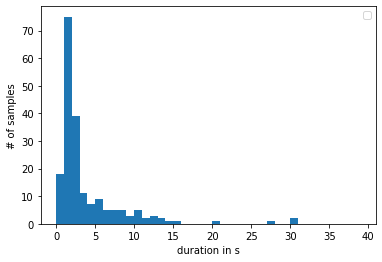

In [4]:
plot_duration_histogram(chunks["right"])

No handles with labels found to put in legend.


Mean 2.75 +/- 4.16


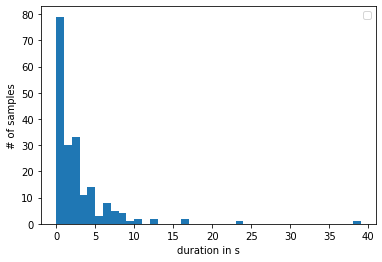

In [5]:
plot_duration_histogram(null_chunks["right"])

In [3]:
# append the action id to the dataframe
# we need to do this to be able to extract time series features later
chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

labels = y.loc[:, "label"].squeeze()

## Classification step 1: OCD activities vs null class samples

### Segmentation

In [4]:
window_size = 50

# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


(1, 0)    OCD activity
(1, 1)    OCD activity
(2, 0)    OCD activity
(3, 0)    OCD activity
(3, 1)    OCD activity
dtype: object


### Feature extraction for OCD activities vs non-OCD activities

In [5]:
X_null_classification = extract_timeseries_features(null_classification_df)

Feature Extraction: 100%|██████████| 20/20 [04:41<00:00, 14.05s/it]


In [11]:
X_null_classification

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

### Feature selection for OCD activities vs non-OCD activities

In [6]:
impute(X_null_classification)
X_null_classification_selected = select_features(X_null_classification, labels_null_classification)


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:173: RuntimeWarning: The columns ['acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"'
 ... 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_97'
 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_98'
 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_99'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [8]:
labels_null_classification

0       OCD activity
1       OCD activity
2       OCD activity
3       OCD activity
4       OCD activity
            ...     
1314      null class
1315      null class
1316      null class
1317      null class
1318      null class
Length: 1319, dtype: object

In [13]:
X_null_classification_selected.loc[:'acceleration x__fft_coefficient__attr_"angle"__coeff_0']

TypeError: '<' not supported between instances of 'tuple' and 'str'

In [19]:
#X_two_handed_selected_null_test

variable,"acceleration x__fft_coefficient__attr_""angle""__coeff_0","acceleration x_right__fft_coefficient__attr_""angle""__coeff_0",acceleration x__count_above__t_0,acceleration x__count_below__t_0,acceleration x__range_count__max_1000000000000.0__min_0,acceleration x__sum_values,acceleration x__mean,"acceleration x__fft_coefficient__attr_""real""__coeff_0",acceleration x__quantile__q_0.4,acceleration x__quantile__q_0.3,...,gyroscope y__variance,"linear_acceleration z__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","linear_acceleration y__fft_coefficient__attr_""angle""__coeff_17",linear_acceleration y_right__number_peaks__n_5,"gyroscope z__fft_coefficient__attr_""abs""__coeff_7",linear_acceleration z_right__number_peaks__n_5,"gyroscope z__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",acceleration x_right__number_peaks__n_5,"acceleration z_right__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0","gyroscope z__fft_coefficient__attr_""abs""__coeff_9"
id,,,,,,,,,,,,,,,,,,,,,
"(1, 0)",0.0,180.0,0.96,0.04,48.0,283.326299,5.666526,283.326299,6.500731,5.841311,...,0.549971,-0.167027,125.562823,3.0,1.048017,3.0,0.064151,0.0,0.019577,1.863100
"(1, 1)",0.0,180.0,1.00,0.00,50.0,258.200899,5.164018,258.200899,3.440431,2.888501,...,0.846304,0.069063,-18.997839,2.0,1.371692,2.0,0.168086,2.0,0.004042,0.539470
"(2, 0)",0.0,0.0,1.00,0.00,50.0,96.455262,1.929105,96.455262,1.710702,1.319194,...,0.299382,-0.174069,-78.348591,2.0,1.713353,4.0,0.047155,4.0,0.004442,1.203228
"(3, 0)",0.0,180.0,0.90,0.10,45.0,155.656883,3.113138,155.656883,1.627941,1.489866,...,1.435712,0.087527,10.639709,3.0,1.021388,1.0,0.034039,2.0,0.012357,0.514520
"(3, 1)",0.0,180.0,0.84,0.16,42.0,231.427987,4.628560,231.427987,4.268252,3.059976,...,5.511056,-0.020586,98.828944,2.0,3.909636,1.0,0.397346,0.0,0.009424,3.469641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(380, 2)",180.0,0.0,0.00,1.00,0.0,-135.870077,-2.717402,-135.870077,-2.785550,-3.448757,...,0.742176,0.109949,86.421902,3.0,2.889048,2.0,0.228611,3.0,0.034013,1.679873
"(382, 0)",180.0,0.0,0.00,1.00,0.0,-162.893250,-3.257865,-162.893250,-3.230572,-4.066340,...,1.657508,0.015575,-2.423290,3.0,2.079268,2.0,0.218863,2.0,0.003764,1.479362
"(383, 0)",180.0,0.0,0.00,1.00,0.0,-147.448660,-2.948973,-147.448660,-3.143711,-3.412570,...,1.754002,0.017066,97.338411,2.0,1.427185,1.0,0.150714,5.0,0.019837,0.767726


In [9]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [21]:
labels_null_classification.values

array([12, 12, 12, ..., 11, 11, 11])

### Train models and score results

In [10]:
print("Two handed classification")
classify_all(X_null_classification, labels_null_classification)

Two handed classification
Logistic Regression: 0.53 +/- 0.08
LDA: 0.50 +/- 0.05
LinearSVC: 0.52 +/- 0.07
CART: 0.50 +/- 0.06
Random Forest: 0.53 +/- 0.14
NB: 0.51 +/- 0.12


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

In [65]:
# TODO: plot feature importance (which feature has the most impact on the results)

import matplotlib.pyplot as plt


def swarm_plot_top_features(data):
    sns.set(style="whitegrid", palette="muted")
    data = pd.melt(data, id_vars=["index", "class"], var_name="features")
    print(data.head())
    plt.figure(figsize=(25,10))
    sns.swarmplot(x="features", y="value", hue="class", data=data)

#sns.pairplot(pd.DataFrame(X_null_classification[:, :10]))

In [51]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

(1, 0)      12
(1, 1)      12
(2, 0)      12
(3, 0)      12
(3, 1)      12
            ..
(380, 2)    11
(382, 0)    11
(383, 0)    11
(383, 1)    11
(384, 0)    11
Length: 1319, dtype: int64

In [42]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


   index         class                                           features  \
0      0  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
1      1  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
2      2  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
3      3  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
4      4  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   

      value  
0 -0.781345  
1 -0.781345  
2 -0.781345  
3 -0.781345  
4 -0.781345  


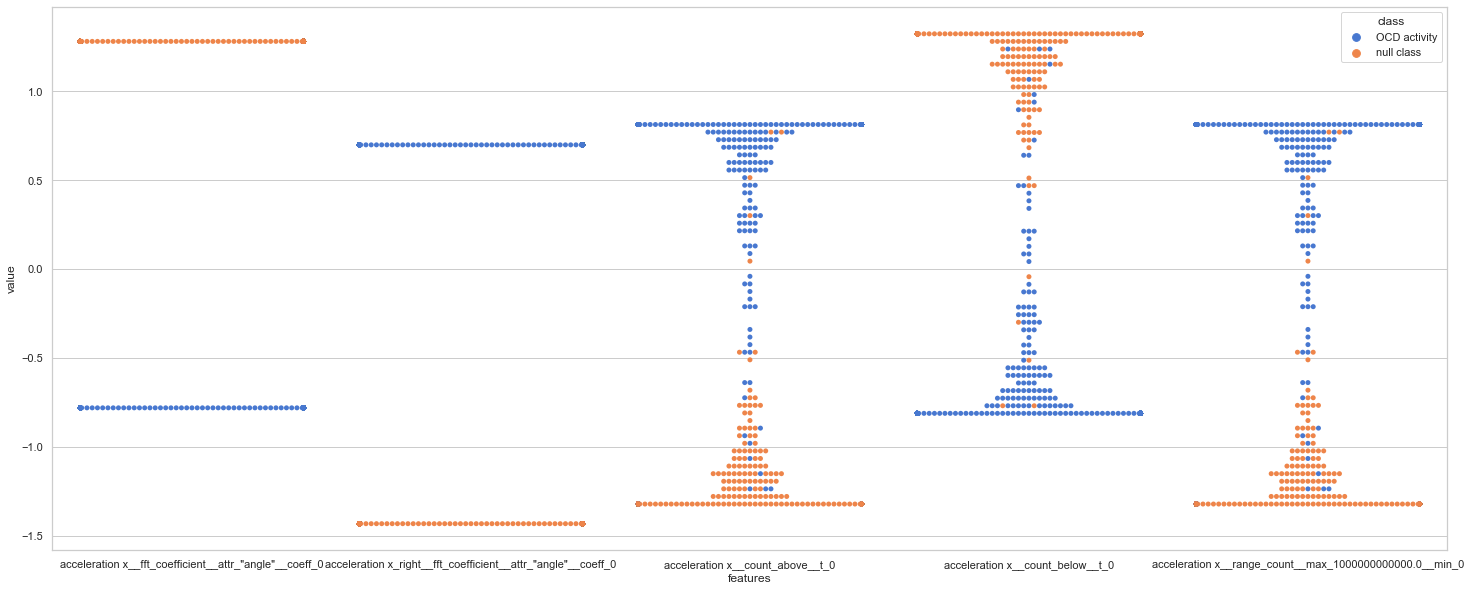

In [69]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_two_handed_selected_null_test.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())
#X_y.reset_index()[:-10]
#X_y.head()

In [ ]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


### Feature extraction for 2 handed classifier of activities against each other

In [ ]:
pd.concat(chunks_two_handed).reset_index(drop=True)

In [ ]:
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

In [ ]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

### Feature selection for 2 handed classifier of activities against each other

In [ ]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

In [ ]:
labels

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)